# ¿Cuántas órdenes hay por código postal?

## Parámetros

In [1]:
BASE_DIR = '/Users/efraflores/Desktop/EF/Corner/Requests/Orders_by_zipcode'
SHP_FOLDER = 'SHP_folder'
CSV_FILE = 'cdmxorders.csv'

## Código

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

from time import time
from numpy import floor, ceil
from pandas import DataFrame, read_csv
from geopandas import GeoDataFrame, GeoSeries, read_file, points_from_xy, sjoin

class OrdersByZipcode:
    def __init__(self, base_dir: str, shp_file: str, csv_file: str) -> None:
        self.base_dir = Path(base_dir)
        self.shp_path = self.base_dir.joinpath(shp_file)
        self.csv_path = self.base_dir.joinpath(csv_file)

    def time_exp(self, start_time, end_time):
        x = end_time - start_time
        minutes, seconds = floor(x/60), 60*(x/60-floor(x/60))
        minutes_str = f"{int(minutes)} minutos con " if minutes > 0 else ""
        if minutes==1: minutes_str = minutes_str.replace('s','')
        return f"{minutes_str}{'{:.2f}'.format(seconds)} segundos"

    def merge_files(self, lat_col: str, lng_col: str) -> None:
        self.shp = read_file(self.shp_path).to_crs(crs="+proj=longlat +datum=WGS84 +no_defs")
        df = read_csv(self.csv_path).sample(frac=0.5)
        df = GeoDataFrame(df, crs='EPSG:6372', geometry=points_from_xy(df[lng_col], df[lat_col], crs='EPSG:6372'))
        self.df = sjoin(self.shp, df)
        del df

    def group_by_chunks(self, df: DataFrame, group_cols: list, value_cols: list, chunk_size: int=50000, verbose: bool=True) -> DataFrame:
        n_chunks = int(ceil(len(self.df)/chunk_size))
        final = DataFrame()
        n = 0
        batch_folder = self.base_dir.joinpath('batches')
        batch_folder.mkdir(exist_ok=True)
        for i in range(n_chunks):
            batch = df.loc[n:n+chunk_size-1,:].groupby(group_cols)[value_cols].count()
            final = final.append(batch, ignore_index=False)
            final.to_csv(batch_folder.joinpath(f'acum_{str(int(i+1)).zfill(2)}.csv'))
            del batch
            n += chunk_size
            if verbose: print(f'Batch {i+1}/{n_chunks} agrupado correctamente')
        final = final.reset_index().groupby(group_cols)[value_cols].sum().reset_index()
        return final

    def group_by_polygon(self, id_col: str) -> GeoDataFrame:
        df = self.df.astype(str)
        df = self.group_by_chunks(df, group_cols=['geometry'], value_cols=['order_id'], verbose=True)
        df = df.merge(self.shp.astype(str)).set_index(id_col)
        df['geometry'] = GeoSeries.from_wkt(df['geometry'])
        self.df = GeoDataFrame(df)
        del df

    def orders_heatmap(self, **kwargs) -> None:
        self.df.plot(**kwargs)
        plt.axis('off')
        plt.show()

    def full_pipeline(self, export_result: bool=True) -> GeoDataFrame:
        start = time()
        self.merge_files(lat_col='lat', lng_col='long')
        print(f'Unido en {self.time_exp(start, time())}!')
        self.group_by_polygon(id_col='d_cp')
        print(f'Agrupado en {self.time_exp(start, time())}!')
        if export_result: self.df.to_csv(self.base_dir.joinpath('orders_by_zipcode.csv'))
        print(f'Exportado en {self.time_exp(start, time())}!')
        self.orders_heatmap(column='order_id', cmap='coolwarm', legend=False)
        print(f'Graficado en {self.time_exp(start, time())}!')
        return self.df


## Transformar

Unido en 42.51 segundos!
Batch 1/9 agrupado correctamente
Batch 2/9 agrupado correctamente
Batch 3/9 agrupado correctamente
Batch 4/9 agrupado correctamente
Batch 5/9 agrupado correctamente
Batch 6/9 agrupado correctamente
Batch 7/9 agrupado correctamente
Batch 8/9 agrupado correctamente
Batch 9/9 agrupado correctamente
Agrupado en 5 minutos con 36.23 segundos!
Exportado en 5 minutos con 36.51 segundos!


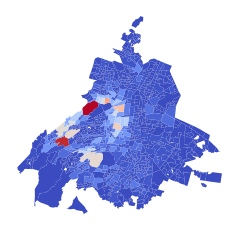

Graficado en 5 minutos con 36.97 segundos!


,geometry,order_id
d_cp,,
09670,"POLYGON ((-99.02230 19.33674, -99.02230 19.336...",2
01296,"POLYGON ((-99.23798 19.37777, -99.23778 19.377...",3
14737,"POLYGON ((-99.23602 19.26992, -99.23599 19.270...",6
05530,"POLYGON ((-99.29477 19.35266, -99.29465 19.352...",226


In [3]:
df = OrdersByZipcode(BASE_DIR, SHP_FOLDER, CSV_FILE).full_pipeline()
df.sample(4)